# Проект: Прогнозирование заказов такси

## Введение

_____
    
**Название проекта**

Прогнозирование заказов такси
_____
**Описание исследования.**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
 
_____
**Задачи исследования.**

1. Загрузка данных
2. Изучение и обработка данных
3. Подготовка выборок для обучения моделей
4. Обучение моделей
5. Анализ времени обучения, времени предсказания и качества моделей
6. Выбор лучшей модели
_____
**Исходные данные.**
    
1. taxi.csv — содержит данные о стоимости автомобилей.
______

**Данное исследование разделим на несколько частей.**

***Часть 1. Загрузка данных:***
1. Загрузка данных из файлов 
2. Получение общей информации о датасете.

***Часть 2. Предобработка данных:***
1. Проверка данных на наличие пропусков, дубликатов и ошибок.
2. Приведение данных к нужным типам и устранение пропусков.

***Часть 3. Исследовательский анализ данных (EDA):***
1. Проведение статистического анализа признаков.
2. Построение графиков для изучения распределений признаков и взаимосвязей между ними.

***Часть 4. Обучение  моделей:***
1. Добавление признаков
2. Использование инструмента подбора гиперпараметров.
3. Обучение моделей прогнозирования.
4. Оценка качества модели на основе метрик и времени обучения. 

***Часть 5. Общий вывод:***
1. Выбор лучшей модели.
2. Выводы для выбранного сегмента покупателей.


## Загрузка данных

___
    Импортируем все необходимые нам библиотеки
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import re


from scipy import stats as st
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    LabelEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error, 
    roc_auc_score,
    mean_absolute_error, 
    accuracy_score, 
    precision_score,
    recall_score, 
    confusion_matrix
)


plt.rcParams["figure.figsize"] = (9,6)
RANDOM_STATE = 42
TEST_SIZE = 0.1

___
    Загрузим данные
___

In [2]:
try:
    df_taxi = pd.read_csv("/kaggle/input/yp-taxi/taxi.csv")

except:
    df_taxi = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv")

---
    Изучим предоставленные данные
---

In [3]:
df_taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


___ 
Обратимся к документации таблицы для определения значений столбцов:
    
**taxi.csv**. Описание данных:

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

1. datetime — дата и время заказа такси
2. num_orders — количество заказов 
___

___ 
    По первичному просмотру данных можно сказать, что:
    1. Пропуски в столбах отсутствуют
    2. Наименования столбцов соответствуют стандартам
    3. datetime необходимо привести к формату даты
___

##  Предобработка данных

---
    На этом этапе, необходимо проверить данные на наличие дубликатов. 
    При необходимости устранить все проблемы с данными.
---

___
    Проверим данные на наличие полных дубликатов и удалим их, если они есть
___

In [5]:
df_taxi.duplicated().sum()

0

---
    Дублиткатов нет
---

---
    Приведём datetime к формату даты
---

In [6]:
df_taxi['datetime'] = pd.to_datetime(df_taxi['datetime'])

___
    Нам необходимо выполнить ресемплирование данных по одному часу
___

In [7]:
df_taxi.set_index('datetime', inplace=True)

In [8]:
df_taxi.index.is_monotonic_increasing

True

In [9]:
df_taxi = df_taxi.resample('1h').sum()

In [10]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


___
    На этом этапе мы:
    - изменили тип у datetime и сделали его индексом
    - провели ресемплирование данных по 1 часу
    
    Можем перейти к Анализу данных
___

## Исследовательский анализ данных



___

    На этом этапе нам предстоит:
    - Провести анализ данных
    - Сделать выводы о данных
___


In [11]:
print(f'Дата min: {df_taxi.index.min()}')
print(f'Дата max: {df_taxi.index.max()}')

Дата min: 2018-03-01 00:00:00
Дата max: 2018-08-31 23:00:00




___

    Мы имеем данные с марта по август 2018 года
___


In [12]:
decomposed = seasonal_decompose(df_taxi)

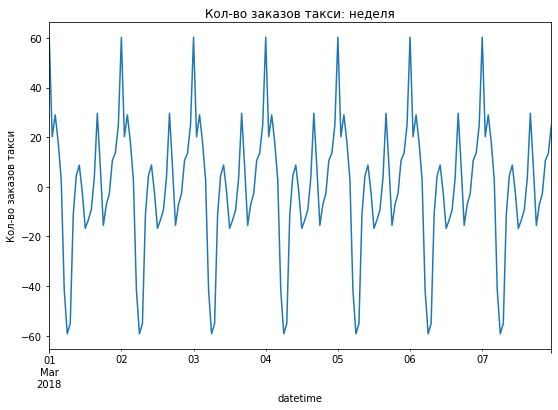

In [13]:
seasonal = decomposed.seasonal

seasonal_mar_15 = seasonal['2018-03-01':'2018-03-07']
plt.xlabel('Временной отрезок')
plt.ylabel('Кол-во заказов такси')
plt.title('Кол-во заказов такси: неделя')
seasonal_mar_15.plot(ax=plt.gca()) 
plt.show()

In [14]:
seasonal.head(24)

datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
2018-03-01 05:00:00   -41.563022
2018-03-01 06:00:00   -59.182671
2018-03-01 07:00:00   -55.104461
2018-03-01 08:00:00   -11.212840
2018-03-01 09:00:00     4.443581
2018-03-01 10:00:00     8.759269
2018-03-01 11:00:00    -2.133377
2018-03-01 12:00:00   -16.721606
2018-03-01 13:00:00   -13.352412
2018-03-01 14:00:00    -9.191665
2018-03-01 15:00:00     3.731832
2018-03-01 16:00:00    29.604100
2018-03-01 17:00:00     7.920016
2018-03-01 18:00:00   -15.527958
2018-03-01 19:00:00    -7.124270
2018-03-01 20:00:00    -2.696560
2018-03-01 21:00:00    10.670243
2018-03-01 22:00:00    13.596814
2018-03-01 23:00:00    25.000503
Freq: H, Name: seasonal, dtype: float64



___

    По  графику видим, что пик нагрузок приходится на полуночь и достаточно много заказов в 16 часа, а самый минимум — в 5-7 утра
___


In [15]:
df_taxi_analize = df_taxi.copy()
df_taxi_analize['rolling_mean'] = df_taxi_analize['num_orders'].rolling(10).mean()
df_taxi_analize['std']          = df_taxi_analize['num_orders'].rolling(10).std()

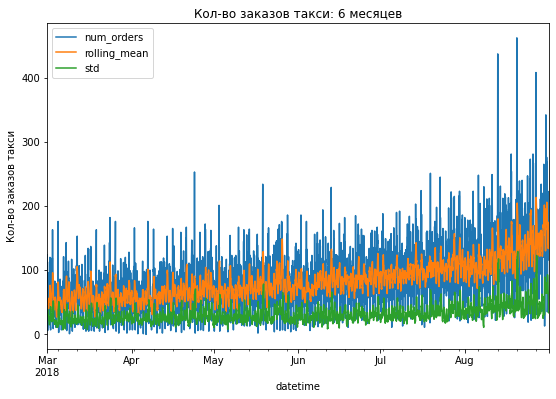

In [16]:
plt.xlabel('Временной отрезок')
plt.ylabel('Кол-во заказов такси')
plt.title('Кол-во заказов такси: 6 месяцев')
df_taxi_analize.plot(ax=plt.gca())
plt.show()



___
    Постепенно от марта к августу заказы такси растут
    Самый пик - в августе
___


___
###    Вывод:

   **Ежедневно**

    Пик нагрузки приходиться на полуночь
    Также, большая нагрузка приходится на 16 часов

    Минимум заказов приходиться на 5-7 утра

   **В общем**

    Постепенно от марта к августу заказы такси растут
    Самый пик - в августе
___

## Обучение моделей

---
    Создадим признаки
---

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
lag = 7
make_features(df_taxi, lag, 5)

---
    Разделим выборку
---

In [19]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

In [20]:
features = ['hour', 'month', 'day', 'dayofweek', 'rolling_mean'] + ['lag_{}'.format(i) for i in range(1, lag)]
X_train = train[features]
y_train = train['num_orders']

X_test = test[features]
y_test = test['num_orders']

---
    Выберем модели, которые будут обучаться
---

In [21]:
pipe_final = Pipeline([
    ('preprocessor', None),
    ('models', None)
])

In [22]:
param_grid = [
    # словарь для модели RandomForestRegressor()
    {
    'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__n_estimators': [50, 100],
    'models__max_depth': [None, 10, 20, 30],
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': [1, 2, 4],
    'models__max_features': ['auto', 'sqrt', 'log2']
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 3, 5, 7, 10], 
        'models__min_samples_split': [2, 5, 10], 
        'models__min_samples_leaf': [1, 2, 4], 
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
    },

]

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor', None),
                                             ('models', None)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [RandomForestRegressor(min_samples_leaf=2,
                                                                          min_samples_split=5,
                                                                          random_state=42)],
                                         'models__max_depth': [None, 10, 20,
                                                               30],
                                         'models__max_features': ['auto',
                                                                  'sqrt...
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
        

___
    Используем метрику RMSE
___

In [24]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor', None),
                ('models',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                                       random_state=42))])
Метрика лучшей модели на тренировочной выборке: -25.577941493233208


___
    Лучшая модель с параметрами:
    RandomForestRegressor(max_features='auto', min_samples_leaf=2, min_samples_split=5, random_state=42)
___

---
    Проверим работу модели на тестовой выборке
    Рассчитаем прогноз на тестовых данных
---

In [25]:
y_test_pred = randomized_search.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Среднее предсказанное кол-во вызовов такси: {y_test_pred.mean():.2f}' )
print(f'Метрика RMSE на тестовой выборке: {rmse:.2f}')

Среднее предсказанное кол-во вызовов такси: 119.28
Метрика RMSE на тестовой выборке: 44.95


## Общий вывод

___
**Вывод**

    Были выполненные такие шаги:
    1. Загрузка данных
    2. Изучение и обработка данных
    3. Обучение моделей
    4. Выбор лучшей модели

    Было выявлено, когда больше  всего заказов такси:
    
   **Ежедневно**
   
    Пик нагрузки приходиться на полуночь
    Также, большая нагрузка приходится на 16 часов
    Минимум заказов приходиться на 5-7 утра
    
   **В общем**
   
    Постепенно от марта к августу заказы такси растут
    Самый пик - в августе

  **Модель**
  
    Была выбрана лучшая модель: RandomForestRegressor 
    С параметрами: max_features='auto', min_samples_leaf=2, min_samples_split=5, random_state=42
    Метрика RMSE на тестовой выборке: 44.95

___